In [ ]:
# Manipulation des donn√©es
import pandas as pd
import re

# Traitement de texte et NLP
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode
import dateparser

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Mod√©lisation th√©matique (Topic Modeling)
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model

# Optimisation hyperparam√®tres
import optuna

# Sauvegarde et chargement de mod√®les
import joblib

# Utilitaires
from collections import Counter
from sklearn.model_selection import train_test_split


In [52]:
df = pd.read_csv("C:/Users/Ahmed Firhoun/Desktop/senego_scrapper/articles_scraped.csv")
df.head()

source      theme                                              titre  \
0  SeneNews  Actualit√©  Gambie : Gros myst√®re autour de la mort du S√©n...   
1  SeneNews  Actualit√©  March√© ASER ‚Äì AEE Power EPC : Les dessous d‚Äôun...   
2  SeneNews      Sport  FSF : Un ancien ministre de Macky Sall pour la...   
3  SeneNews  Actualit√©  Drame √† S√©dhiou : Un adolescent foudroy√© en pl...   
4  SeneNews  Actualit√©  Le dossier br√ªlant du lotissement du Hangar P√®...   

                 date       date_parsed              auteur  \
0  16/06/2025 √† 11:21  2025-06-16 11:21       Thierno Gueye   
1  16/06/2025 √† 11:03  2025-06-16 11:03  Modou Mamoune Tine   
2  16/06/2025 √† 10:58  2025-06-16 10:58       Thierno Gueye   
3  16/06/2025 √† 10:54  2025-06-16 10:54        Khadija S√®ne   
4  16/06/2025 √† 10:41  2025-06-16 10:41       Thierno Gueye   

                                             contenu  \
0  La police gambienne a annonc√© l‚Äôarrestation de...   
1                                                NaN   
2  L‚Äôancien ministre de l‚ÄôUrbanisme, du Logement ...   
3  Le village de Sansamba, dans la r√©gion de S√©dh...   
4  Au pr√©sident de la R√©publique, Bassirou Diomay...   

                                                 url  
0  https://www.senenews.com/actualites/gambie-gro...  
1  https://www.senenews.com/actualites/marche-ase...  
2  https://www.senenews.com/actualites/fsf-un-anc...  
3  https://www.senenews.com/actualites/drame-a-se...  
4  https://www.senenews.com/actualites/le-dossier...

# 1.Exploration des donn√©es

## 1.1 Types des variables

In [53]:
df.dtypes

source         object
theme          object
titre          object
date           object
date_parsed    object
auteur         object
contenu        object
url            object
dtype: object

In [54]:
def parse_mixed_datetime(date_str):
    return dateparser.parse(date_str, languages=['fr'])

df['date'] = df['date'].apply(parse_mixed_datetime)
df['date_parsed'] = df['date_parsed'].apply(parse_mixed_datetime)
df.dtypes

source                 object
theme                  object
titre                  object
date           datetime64[ns]
date_parsed    datetime64[ns]
auteur                 object
contenu                object
url                    object
dtype: object

## 1.2 Description

In [55]:
df.head()

source      theme                                              titre  \
0  SeneNews  Actualit√©  Gambie : Gros myst√®re autour de la mort du S√©n...   
1  SeneNews  Actualit√©  March√© ASER ‚Äì AEE Power EPC : Les dessous d‚Äôun...   
2  SeneNews      Sport  FSF : Un ancien ministre de Macky Sall pour la...   
3  SeneNews  Actualit√©  Drame √† S√©dhiou : Un adolescent foudroy√© en pl...   
4  SeneNews  Actualit√©  Le dossier br√ªlant du lotissement du Hangar P√®...   

                 date date_parsed              auteur  \
0 2025-06-16 11:21:00         NaT       Thierno Gueye   
1 2025-06-16 11:03:00         NaT  Modou Mamoune Tine   
2 2025-06-16 10:58:00         NaT       Thierno Gueye   
3 2025-06-16 10:54:00         NaT        Khadija S√®ne   
4 2025-06-16 10:41:00         NaT       Thierno Gueye   

                                             contenu  \
0  La police gambienne a annonc√© l‚Äôarrestation de...   
1                                                NaN   
2  L‚Äôancien ministre de l‚ÄôUrbanisme, du Logement ...   
3  Le village de Sansamba, dans la r√©gion de S√©dh...   
4  Au pr√©sident de la R√©publique, Bassirou Diomay...   

                                                 url  
0  https://www.senenews.com/actualites/gambie-gro...  
1  https://www.senenews.com/actualites/marche-ase...  
2  https://www.senenews.com/actualites/fsf-un-anc...  
3  https://www.senenews.com/actualites/drame-a-se...  
4  https://www.senenews.com/actualites/le-dossier...

In [56]:
df.describe(include='all')

source      theme                                              titre  \
count      578        578                                                578   
unique       2         12                                                577   
top     Senego  Actualit√©  Etats-Unis : Les raisons de l‚Äôannulation du vo...   
freq       303        134                                                  2   
mean       NaN        NaN                                                NaN   
min        NaN        NaN                                                NaN   
25%        NaN        NaN                                                NaN   
50%        NaN        NaN                                                NaN   
75%        NaN        NaN                                                NaN   
max        NaN        NaN                                                NaN   

                                 date                    date_parsed   auteur  \
count                             578                            312      578   
unique                            NaN                            NaN       20   
top                               NaN                            NaN  Faty BA   
freq                              NaN                            NaN      106   
mean    2025-06-12 19:17:18.788927232  2025-10-25 05:29:01.153846272      NaN   
min               2025-06-07 08:50:00            2025-07-06 00:00:00      NaN   
25%               2025-06-11 13:30:45            2025-10-06 00:00:00      NaN   
50%               2025-06-12 18:05:00            2025-11-06 00:00:00      NaN   
75%               2025-06-14 09:47:00            2025-12-06 00:00:00      NaN   
max               2025-06-16 11:27:00            2025-12-06 23:51:00      NaN   

                                                  contenu  \
count                                                 552   
unique                                                546   
top     Pourquoi vous devez soutenir l‚Äôinitiative Sene...   
freq                                                    7   
mean                                                  NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                                      url  
count                                                 578  
unique                                                578  
top     https://www.senenews.com/actualites/gambie-gro...  
freq                                                    1  
mean                                                  NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

In [57]:
df.head()

source      theme                                              titre  \
0  SeneNews  Actualit√©  Gambie : Gros myst√®re autour de la mort du S√©n...   
1  SeneNews  Actualit√©  March√© ASER ‚Äì AEE Power EPC : Les dessous d‚Äôun...   
2  SeneNews      Sport  FSF : Un ancien ministre de Macky Sall pour la...   
3  SeneNews  Actualit√©  Drame √† S√©dhiou : Un adolescent foudroy√© en pl...   
4  SeneNews  Actualit√©  Le dossier br√ªlant du lotissement du Hangar P√®...   

                 date date_parsed              auteur  \
0 2025-06-16 11:21:00         NaT       Thierno Gueye   
1 2025-06-16 11:03:00         NaT  Modou Mamoune Tine   
2 2025-06-16 10:58:00         NaT       Thierno Gueye   
3 2025-06-16 10:54:00         NaT        Khadija S√®ne   
4 2025-06-16 10:41:00         NaT       Thierno Gueye   

                                             contenu  \
0  La police gambienne a annonc√© l‚Äôarrestation de...   
1                                                NaN   
2  L‚Äôancien ministre de l‚ÄôUrbanisme, du Logement ...   
3  Le village de Sansamba, dans la r√©gion de S√©dh...   
4  Au pr√©sident de la R√©publique, Bassirou Diomay...   

                                                 url  
0  https://www.senenews.com/actualites/gambie-gro...  
1  https://www.senenews.com/actualites/marche-ase...  
2  https://www.senenews.com/actualites/fsf-un-anc...  
3  https://www.senenews.com/actualites/drame-a-se...  
4  https://www.senenews.com/actualites/le-dossier...

## 1.3 Valeurs manquantes

In [58]:
# Nombre de NA par variable
na_counts = df.isna().sum()

# Afficher le r√©sultat
print(na_counts)

source           0
theme            0
titre            0
date             0
date_parsed    266
auteur           0
contenu         26
url              0
dtype: int64


In [59]:
df = df.dropna(subset=['contenu'])
df = df.drop(columns=['date_parsed'])
# Nombre de NA par variable
na_counts = df.isna().sum()

# Afficher le r√©sultat
print(na_counts)

source     0
theme      0
titre      0
date       0
auteur     0
contenu    0
url        0
dtype: int64


## 1.1 Articles par rubriques

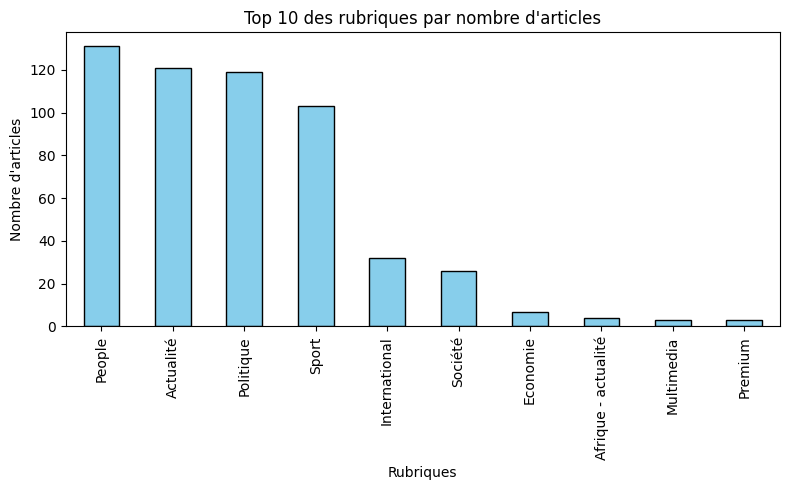

In [60]:
compte_rubrique = df['theme'].value_counts().head(10)

# Afficher le graphique
plt.figure(figsize=(8, 5))
compte_rubrique.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top 10 des rubriques par nombre d'articles")
plt.xlabel("Rubriques")
plt.ylabel("Nombre d'articles")
plt.tight_layout()
plt.show()

## 1.2 Articles par auteurs

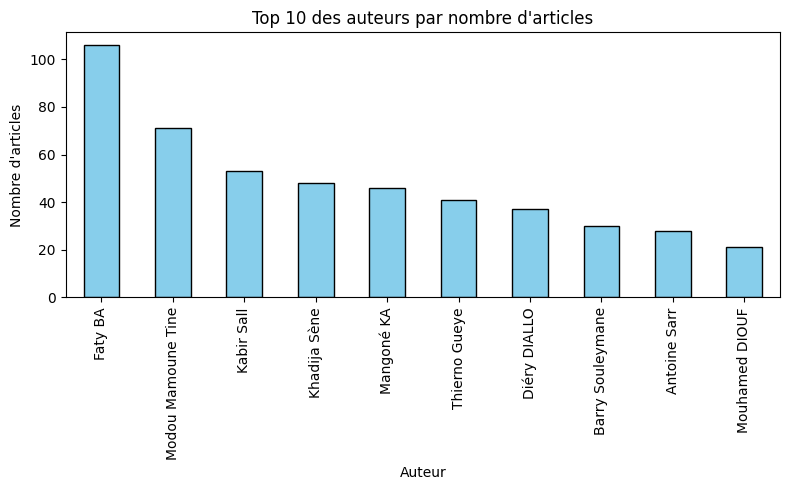

In [ ]:
compte_auteurs = df['auteur'].value_counts().head(10)
plt.figure(figsize=(8, 5))
compte_auteurs.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top 10 des auteurs par nombre d'articles")
plt.xlabel("Auteur")
plt.ylabel("Nombre d'articles")
plt.tight_layout()
plt.show()

## 1.2 Article le plus r√©cent

In [ ]:
article_recent = df.loc[df['date'].idxmax()]

print("Article le plus r√©cent :\n")
print(f"Titre     : {article_recent['titre']}")
print(f"Auteur    : {article_recent['auteur']}")
print(f"Date      : {article_recent['date']}")
print(f"Rubrique  : {article_recent['theme']}")
print(f"Source    : {article_recent['source']}")
print(f"URL       : {article_recent['url']}")


üìå Article le plus r√©cent :

Titre     : CENA en CENI : ¬´¬†Pas modifier ce qui fonctionne¬†¬ª, selon l‚Äôopposition au Dialogue national
Auteur    : Mangon√© KA
Date      : 2025-06-16 11:27:00
Rubrique  : Politique
Source    : Senego
URL       : https://senego.com/cena-en-ceni-pas-modifier-ce-qui-fonctionne-selon-lopposition-au-dialogue-national_1849149.html


## 1.4 Articles par sources

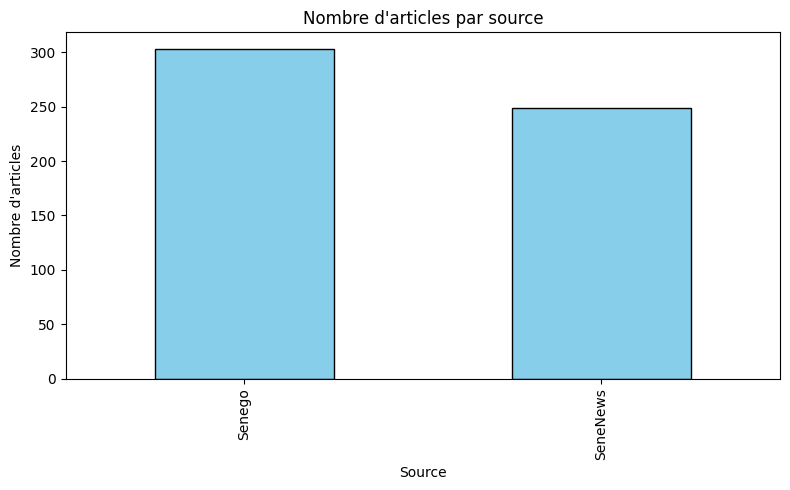

In [ ]:

compte_source = df['source'].value_counts()
plt.figure(figsize=(8, 5))
compte_source.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Nombre d'articles par source")
plt.xlabel("Source")
plt.ylabel("Nombre d'articles")
plt.tight_layout()
plt.show()

## 1.5 Nombre d'articles par jour

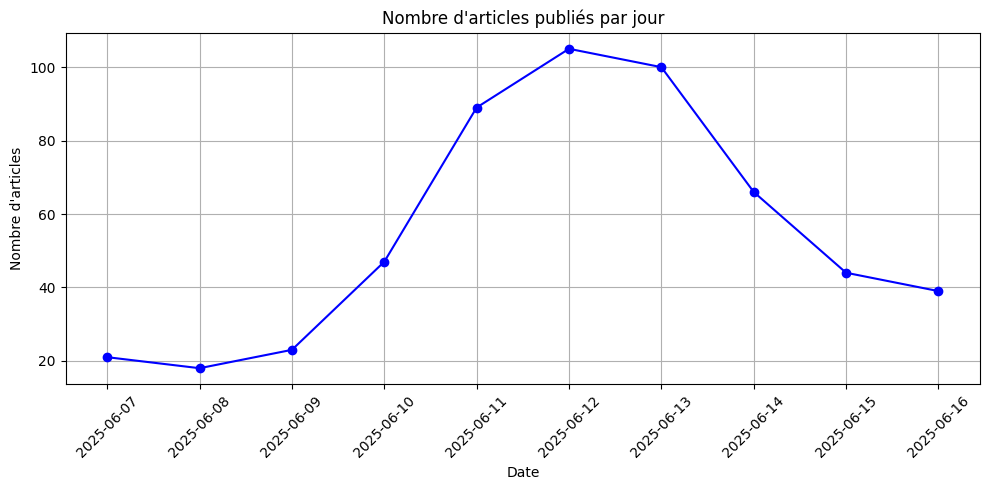

In [ ]:
df['date_only'] = df['date'].dt.date
articles_par_jour = df.groupby('date_only').size()
plt.figure(figsize=(10, 5))
articles_par_jour.plot(kind='line', marker='o', color='blue')
plt.title("Nombre d'articles publi√©s par jour")
plt.xlabel("Date")
plt.ylabel("Nombre d'articles")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 1.5 Nombre d'articles par jour par source

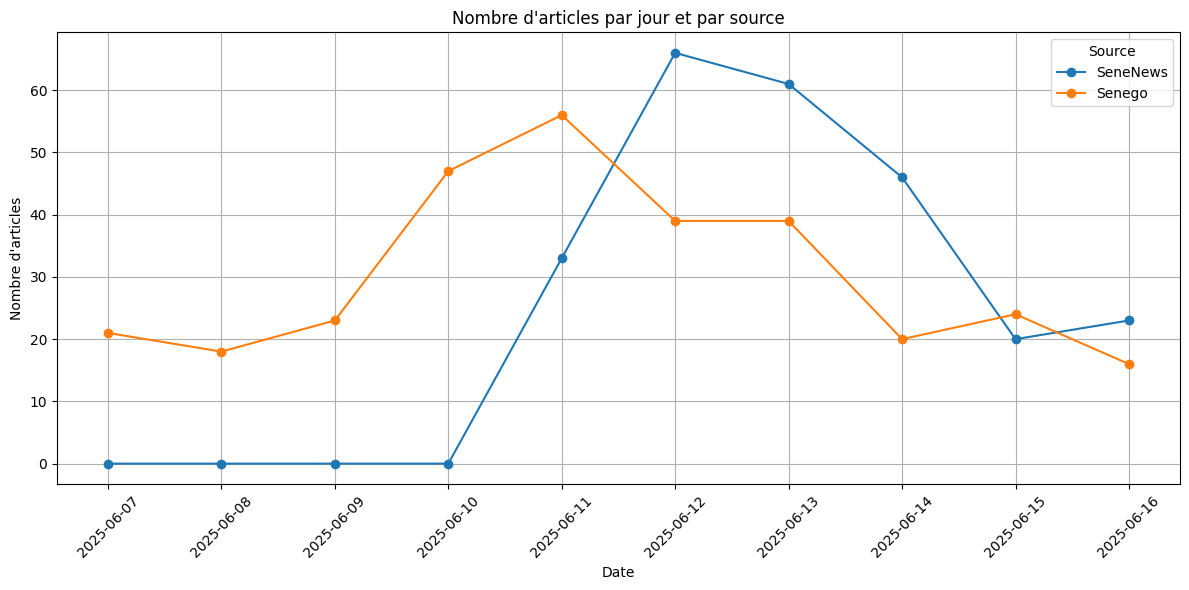

In [ ]:
df['date_only'] = df['date'].dt.date
articles_jour_source = df.groupby(['date_only', 'source']).size().unstack(fill_value=0)
plt.figure(figsize=(12,6))
for source in articles_jour_source.columns:
    plt.plot(articles_jour_source.index, articles_jour_source[source], marker='o', label=source)

plt.title("Nombre d'articles par jour et par source")
plt.xlabel("Date")
plt.ylabel("Nombre d'articles")
plt.xticks(rotation=45)
plt.legend(title='Source')
plt.grid(True)
plt.tight_layout()
plt.show()


## 1.5 Nombre d'articles par jour par rubrique

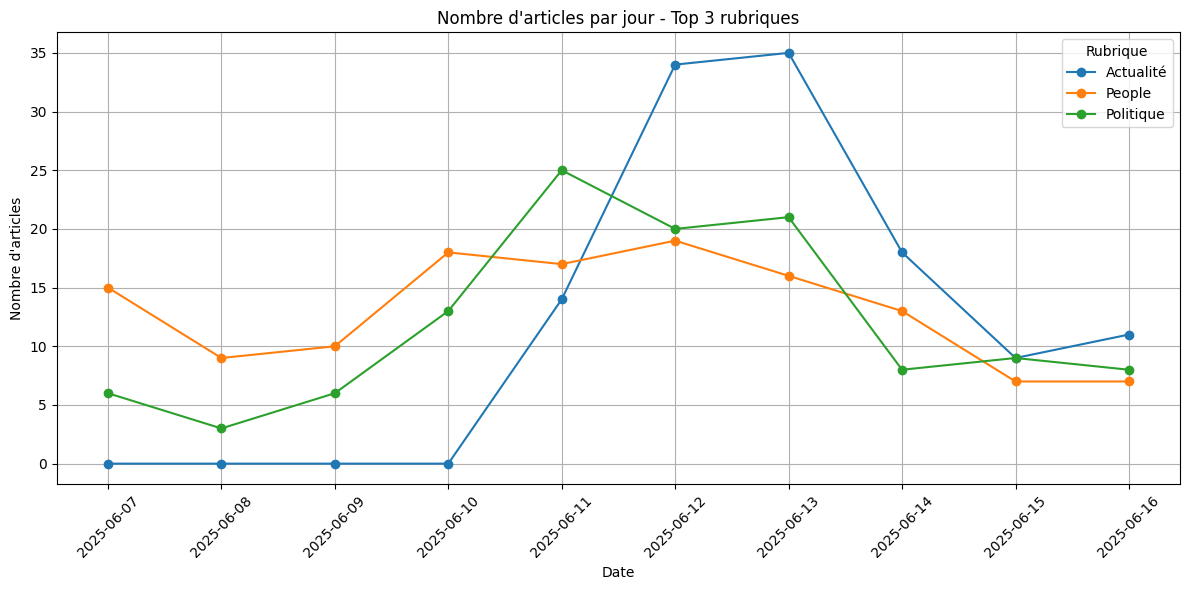

In [66]:
df['date_only'] = df['date'].dt.date

# Calcul total des articles par rubrique (theme)
total_par_theme = df['theme'].value_counts()

# Top 5 rubriques
top5_themes = total_par_theme.head(3).index.tolist()

# Filtrer le DataFrame pour ne garder que ces rubriques
df_top5 = df[df['theme'].isin(top5_themes)]

# Grouper par date et th√®me, puis pivoter
articles_jour_theme_top5 = df_top5.groupby(['date_only', 'theme']).size().unstack(fill_value=0)

# Tracer le lineplot
plt.figure(figsize=(12,6))
for theme in articles_jour_theme_top5.columns:
    plt.plot(articles_jour_theme_top5.index, articles_jour_theme_top5[theme], marker='o', label=theme)

plt.title("Nombre d'articles par jour - Top 3 rubriques")
plt.xlabel("Date")
plt.ylabel("Nombre d'articles")
plt.xticks(rotation=45)
plt.legend(title='Rubrique')
plt.grid(True)
plt.tight_layout()
plt.show()

## 1.6 Histogramme du nombre de mots

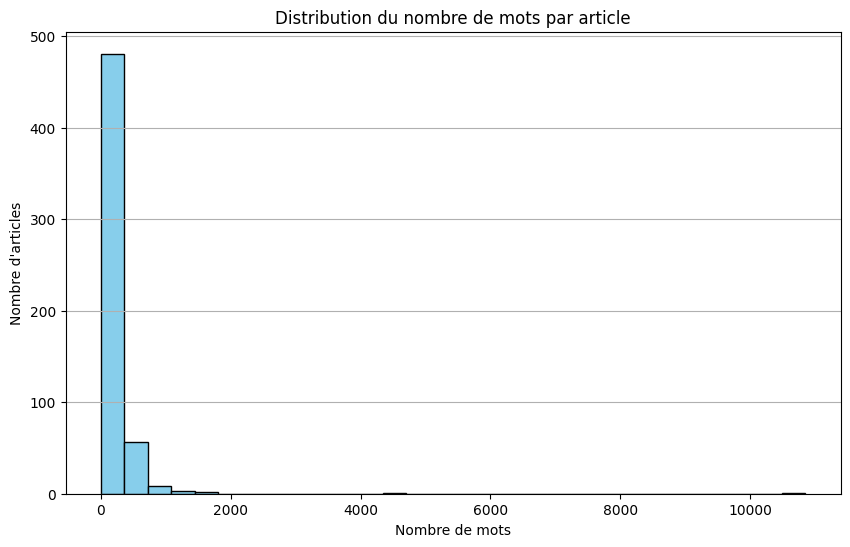

In [ ]:
# Remplacer les NaN par cha√Æne vide
df['contenu_clean'] = df['contenu'].fillna('')

# Calculer le nombre de mots
df['nb_mots'] = df['contenu_clean'].str.split().apply(len)

plt.figure(figsize=(10,6))
plt.hist(df['nb_mots'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution du nombre de mots par article")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre d'articles")
plt.grid(axis='y')
plt.show()


# 2. Topic Modeling

In [68]:
# T√©l√©charger les stopwords fran√ßais
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

[nltk_data] Downloading package stopwords to C:\Users\Ahmed
[nltk_data]     Firhoun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Fusionner les stopwords : WordCloud + NLTK + tes mots perso
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(stopwords.words('french'))
custom_stopwords.update(ENGLISH_STOP_WORDS)  # Parfois utile si m√©lange anglais/fran√ßais

# Ajouter tes propres mots
custom_stopwords.update([
    'selon', 'ce', 'cet', 'cette', 'dont', 'ainsi', 'hgroupe', 'ete', 'aussi','field','plus',
    'dun', 'dune', 'cest', 'comme', 'juin', 'apres', 'deux', 'senegal','senegalais','juingroupe',
    'sest','lors','egalement','sans','notamment', 'quil', 'tout', 'tous', 'fait','entre',
    'titre','plusieurs','sous','faire','bien','meme','avant','toujours','cela','face','tres',
    'leur','leurs','toute','toutes','vers','quelle','jai','etait','etais','senegalaise',
    'alors','encore','avoir','nest', 'etre',
    ])

[nltk_data] Downloading package stopwords to C:\Users\Ahmed
[nltk_data]     Firhoun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2.1 Preprocessing

In [70]:
def preprocess(text):
    text = str(text).lower()                      # minuscules
    text = unidecode(text)                        # enlever les accents
    text = text.replace("'", " ")                 # remplacer les apostrophes par des espaces
    text = re.sub(r'\d+', '', text)               # enlever les chiffres
    text = re.sub(r'[^\w\s]', '', text)           # enlever la ponctuation sauf apostrophes d√©j√† trait√©es
    tokens = text.split()                         # tokenisation simple
    tokens = [word for word in tokens if word not in custom_stopwords and len(word) > 2]
    return ' '.join(tokens)

# Application
df['cleaned_content'] = df['contenu'].apply(preprocess)


In [71]:
df['cleaned_content'].head()

0    police gambienne annonce arrestation individus...
2    ancien ministre urbanisme logement hygiene pub...
3    village sansamba region sedhiou choc mort trag...
4    president republique bassirou diomaye faye pre...
5    invitee emission pape cheikh diallo influenceu...
Name: cleaned_content, dtype: object

## 2.2 Vectorisation

In [72]:
# Cr√©er un vecteur de type Bag of Words
vectorizer = CountVectorizer(max_df=0.95, min_df=2)  # on ignore les mots trop fr√©quents et trop rares
X = vectorizer.fit_transform(df['cleaned_content'])

# Afficher la taille du vocabulaire
print(f"Nombre de mots uniques retenus : {len(vectorizer.get_feature_names_out())}")

Nombre de mots uniques retenus : 5541


## 2.3 Analyse exploratoire

### 2.3.1 Mots les plus fr√©quents

In [ ]:
# Compter tous les mots du corpus nettoy√©
all_words = ' '.join(df['cleaned_content']).split()
word_freq = Counter(all_words)

# Afficher les 20 mots les plus fr√©quents
print("Mots les plus fr√©quents (corpus global) :\n")
for word, freq in word_freq.most_common(50):
    print(f"{word}: {freq}")

üî† Mots les plus fr√©quents (corpus global) :

stadium: 492
city: 229
president: 218
ministre: 194
etat: 190
seattle: 155
ministere: 148
pays: 146
contre: 145
inter: 137
monde: 133
premier: 129
los: 119
angeles: 119
miami: 117
kawtef: 115
nomme: 114
dakar: 113
ans: 111
lincoln: 111
financial: 111
philadelphie: 111
madrid: 110
nationale: 108
republique: 106
rose: 106
bowl: 106
place: 105
lumen: 105
chef: 104
national: 102
hard: 102
rock: 102
football: 101
ancien: 100
monsieur: 100
politique: 97
remplacement: 96
moustapha: 95
real: 94
faye: 93
new: 93
york: 90
ndiaye: 89
club: 89
developpement: 89
atil: 88
nouvelle: 87
situation: 87
directeur: 86


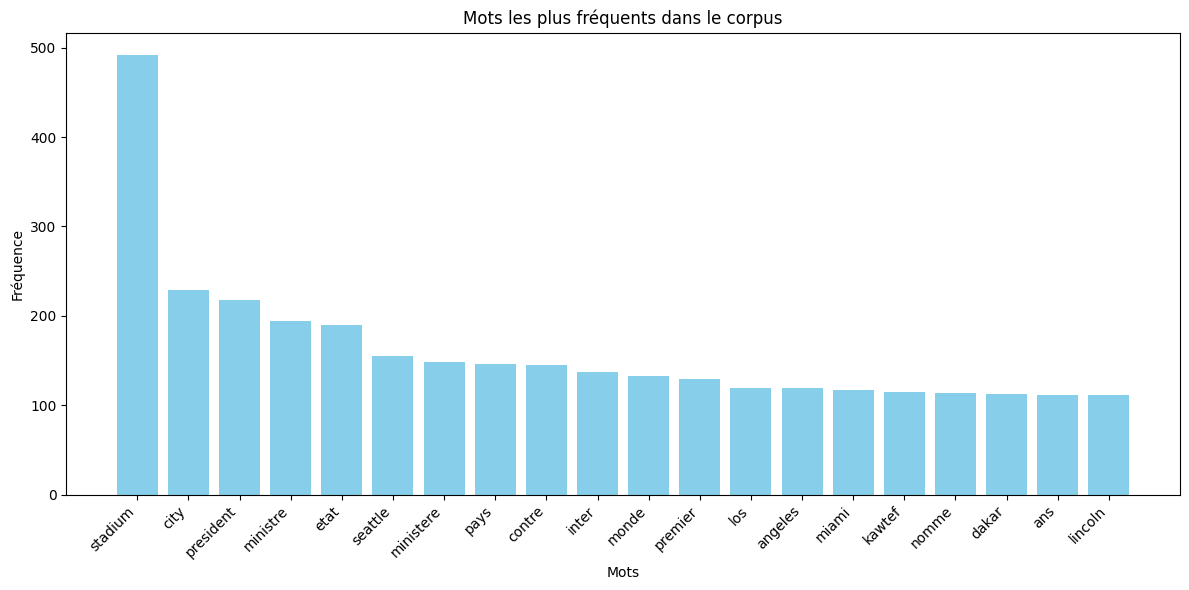

In [74]:
# S√©lectionner les 20 mots les plus fr√©quents
most_common_words = word_freq.most_common(20)
words, freqs = zip(*most_common_words)

# Tracer le graphique
plt.figure(figsize=(12, 6))
plt.bar(words, freqs, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Mots les plus fr√©quents dans le corpus')
plt.xlabel('Mots')
plt.ylabel('Fr√©quence')
plt.tight_layout()
plt.show()

### 2.3.2 Nuage des mots

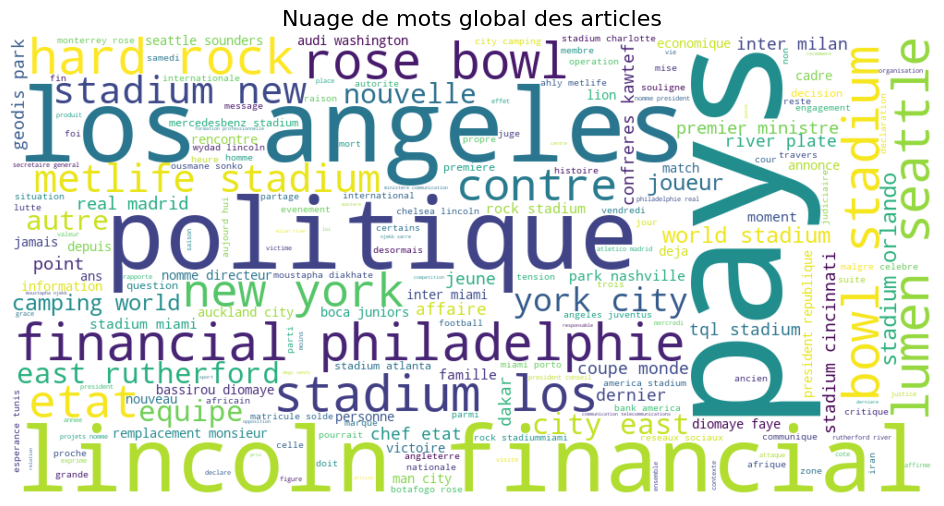

In [75]:
# Combiner tout le texte nettoy√©
text_total = ' '.join(df['cleaned_content'])

# G√©n√©rer le nuage de mots
wordcloud_global = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    stopwords='french',
    max_words=200
).generate(text_total)

# Afficher le nuage
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_global, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots global des articles", fontsize=16)
plt.show()


## 2.4 Topic Modeling avec Latent Dirichlet Allocation (LDA)

### 2.4.1 Optimisation des hyperparam√®tres

In [ ]:
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

def objective(trial):
    n_components = trial.suggest_int('n_components', 3, 15)
    learning_decay = trial.suggest_float('learning_decay', 0.5, 0.9)
    learning_offset = trial.suggest_int('learning_offset', 10, 100)

    lda = LatentDirichletAllocation(
        n_components=n_components,
        learning_method='online',
        learning_decay=learning_decay,
        learning_offset=learning_offset,
        max_iter=10,
        random_state=42
    )
    lda.fit(X_train)
    # On √©value la perplexit√© sur validation
    perplexity = lda.perplexity(X_val)
    return perplexity  # objectif : minimiser la perplexit√©

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Meilleurs param√®tres : ", study.best_params)
print("Meilleure perplexit√© :", study.best_value)

best_params = study.best_params


C:\Users\Ahmed Firhoun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(
[I 2025-06-17 09:23:49,725] A new study created in memory with name: no-name-f289f4af-952a-436a-8a14-0a0e1752f7a8
[I 2025-06-17 09:23:51,354] Trial 0 finished with value: 496281.0678455702 and parameters: {'n_components': 10, 'learning_decay': 0.837301372477335, 'learning_offset': 70}. Best is trial 0 with value: 496281.0678455702.
[I 2025-06-17 09:23:53,014] Trial 1 finished with value: 34065.589059615726 and parameters: {'n_components': 6, 'learning_decay': 0.7019219202909527, 'learning_offset': 8

Meilleurs param√®tres :  {'n_components': 3, 'learning_decay': 0.8646649155165673, 'learning_offset': 59}
Meilleure perplexit√© : 13591.875142053446


In [ ]:
best_lda = LatentDirichletAllocation(
    n_components=best_params['n_components'],
    learning_method='online',
    learning_decay=best_params['learning_decay'],
    learning_offset=best_params['learning_offset'],
    max_iter=20,
    random_state=42
)

best_lda.fit(X) 

LatentDirichletAllocation(learning_decay=0.8646649155165673,
                          learning_method='online', learning_offset=59,
                          max_iter=20, n_components=3, random_state=42)

In [ ]:
# Sauvegarder le mod√®le
joblib.dump(best_lda, './models/best_lda_model.joblib')
# Pour le recharger plus tard
best_lda_loaded = joblib.load('./models/best_lda_model.joblib')


### 2.4.2 Nombre d'articles par Topic

In [78]:
# Obtenir la distribution des topics par document
topic_distribution = best_lda.transform(X)

# Ajouter le topic dominant dans le DataFrame
df['topic'] = topic_distribution.argmax(axis=1)

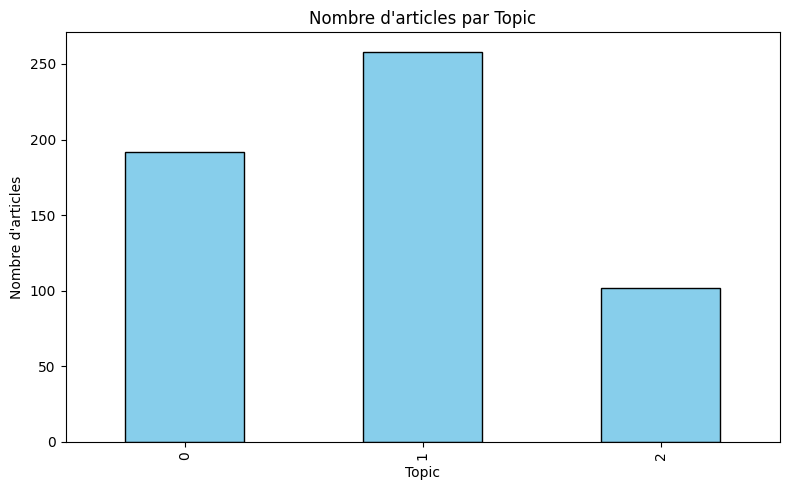

In [79]:
compte_topic = df['topic'].value_counts().sort_index()

# Afficher le graphique
plt.figure(figsize=(8, 5))
compte_topic.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Nombre d'articles par Topic")
plt.xlabel("Topic")
plt.ylabel("Nombre d'articles")
plt.tight_layout()
plt.show()

### 2.4.3 Diff√©rents topic avec les mots les plus fr√©quents ressortis

In [ ]:
def display_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n Topic {topic_idx + 1}")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

display_topics(best_lda, vectorizer.get_feature_names_out())



üü¶ Topic 1
president, ministre, etat, ministere, pays, chef, republique, nomme, politique, national

üü¶ Topic 2
kawtef, tabaski, confreres, fete, famille, site, occasion, evenement, vie, enquete

üü¶ Topic 3
stadium, city, inter, los, angeles, miami, madrid, club, real, new


In [ ]:
# Compter les mots par topic
for topic in sorted(df['topic'].unique()):
    all_topic_words = ' '.join(df[df['topic'] == topic]['cleaned_content']).split()
    topic_freq = Counter(all_topic_words)
    print(f"\n Topic {topic} - mots les plus fr√©quents :")
    for word, freq in topic_freq.most_common(10):
        print(f"{word}: {freq}")


üî† Topic 0 - mots les plus fr√©quents :
president: 202
ministre: 185
etat: 146
ministere: 129
nomme: 111
pays: 100
chef: 98
monsieur: 98
remplacement: 96
national: 94

üî† Topic 1 - mots les plus fr√©quents :
kawtef: 107
confreres: 76
tabaski: 67
famille: 66
points: 58
enquete: 56
vie: 52
fete: 50
place: 48
contre: 47

üî† Topic 2 - mots les plus fr√©quents :
stadium: 492
city: 227
seattle: 155
inter: 136
los: 117
angeles: 117
miami: 117
lincoln: 111
financial: 111
philadelphie: 111


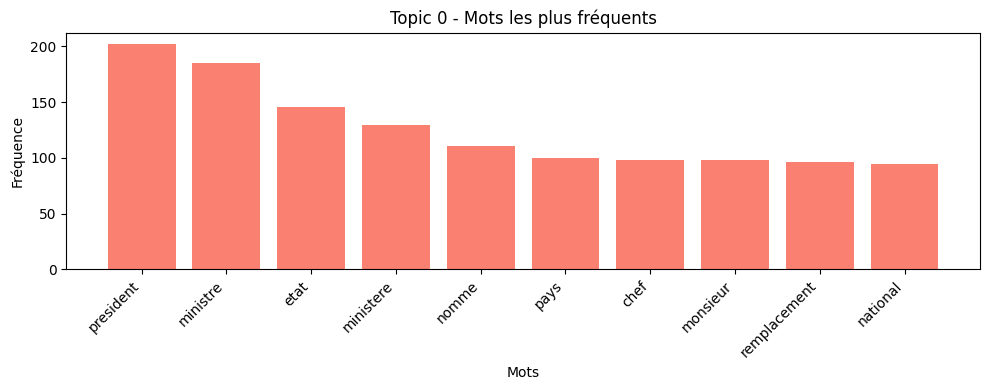

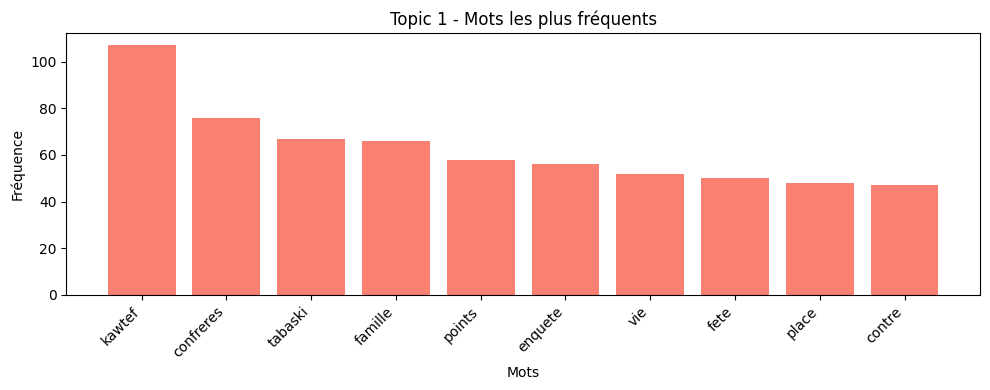

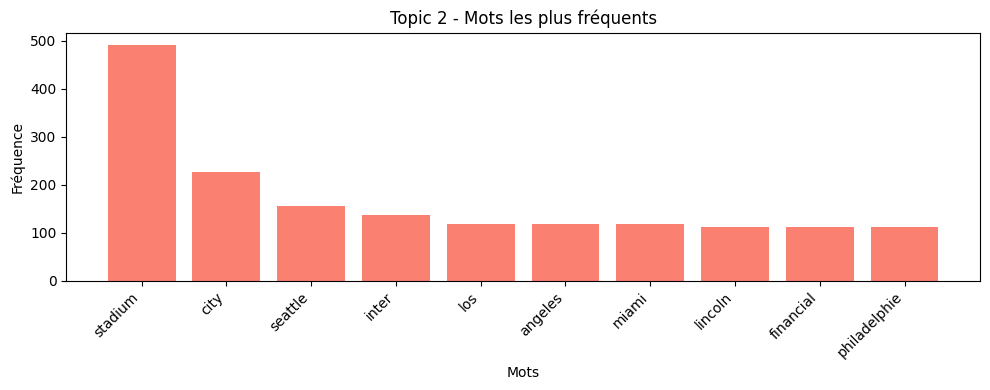

In [82]:
# D√©finir le nombre de mots √† afficher
TOP_N = 10

# It√©rer sur les topics
for topic in sorted(df['topic'].unique()):
    all_topic_words = ' '.join(df[df['topic'] == topic]['cleaned_content']).split()
    topic_freq = Counter(all_topic_words)
    most_common = topic_freq.most_common(TOP_N)

    if most_common:  # V√©rifie qu'il y a bien du texte
        words, freqs = zip(*most_common)

        # Tracer le graphique
        plt.figure(figsize=(10, 4))
        plt.bar(words, freqs, color='salmon')
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Topic {topic} - Mots les plus fr√©quents')
        plt.xlabel('Mots')
        plt.ylabel('Fr√©quence')
        plt.tight_layout()
        plt.show()


### 2.4.5 Nuage de mots par Topic

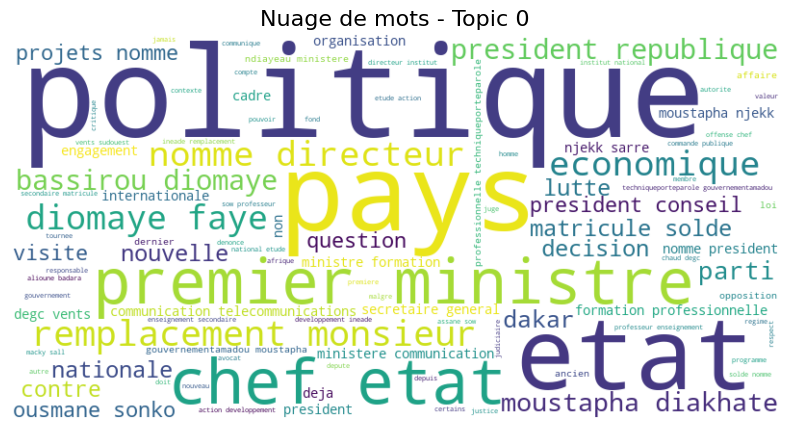

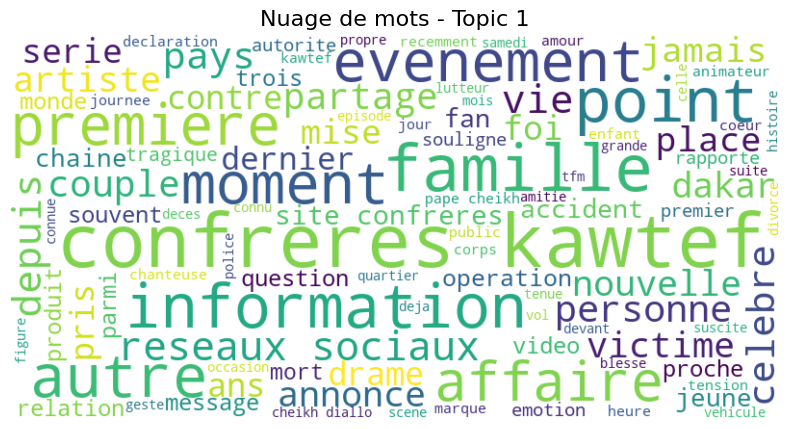

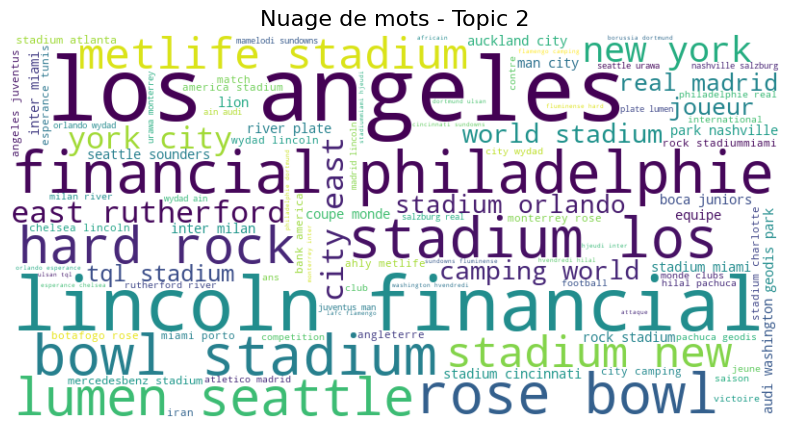

In [83]:
# Cr√©er un nuage de mots pour chaque topic
for topic_num in sorted(df['topic'].unique()):
    texts = df[df['topic'] == topic_num]['cleaned_content']
    text_combined = ' '.join(texts)

    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords='french', max_words=100).generate(text_combined)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuage de mots - Topic {topic_num}', fontsize=16)
    plt.show()


### 2.4.6 Rubriques par Topic

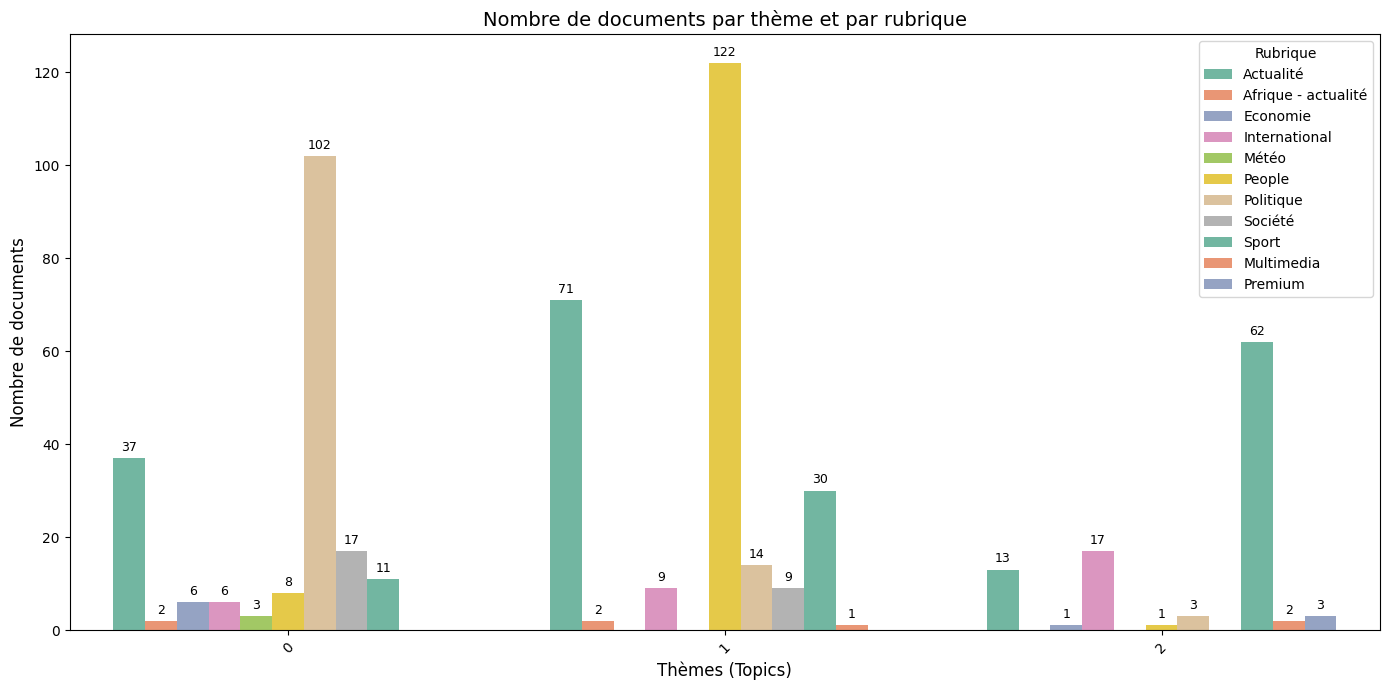

In [84]:
# Cr√©er un tableau de contingence rubrique vs topic
rubrique_topic_counts = df.groupby(['topic', 'theme']).size().reset_index(name='Nombre de documents')
# Cr√©er la figure
plt.figure(figsize=(14, 7))

# Barplot avec palette claire
ax = sns.barplot(
    data=rubrique_topic_counts,  # ton DataFrame regroup√©
    x='topic',
    y='Nombre de documents',
    hue='theme',
    palette='Set2'
)

# Ajouter les annotations (valeurs) sur les barres
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=3)

# Am√©liorer les labels et la lisibilit√©
plt.xlabel("Th√®mes (Topics)", fontsize=12)
plt.ylabel("Nombre de documents", fontsize=12)
plt.title("Nombre de documents par th√®me et par rubrique", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Rubrique")

plt.show()



### 2.4.7 Quelques statistiques descriptives par Topic

In [85]:
# Regroupement par topic dominant
grouped = df.groupby('topic')

stats = pd.DataFrame({
    'Nombre d\'articles': grouped.size(),
    'Proportion du corpus(%)': grouped.size() / len(df) * 100,
    'Longueur moyenne (mots)': grouped['nb_mots'].mean(),
    'Date min': grouped['date'].min(),
    'Date max': grouped['date'].max()
})

# Calcul de l'√©tendue en jours
stats['Etendue (jours)'] = (stats['Date max'] - stats['Date min']).dt.days

stats.head()


Nombre d'articles  Proportion du corpus(%)  Longueur moyenne (mots)  \
topic                                                                        
0                    192                34.782609               278.520833   
1                    258                46.739130               160.790698   
2                    102                18.478261               311.509804   

                 Date min            Date max  Etendue (jours)  
topic                                                           
0     2025-06-07 11:34:00 2025-06-16 11:27:00                8  
1     2025-06-07 08:50:00 2025-06-16 11:21:00                9  
2     2025-06-08 08:50:00 2025-06-16 10:14:00                8

In [86]:
# Afficher la distribution des th√®mes par topic
print("\nDistribution des th√®mes par topic :")
for topic, group in grouped:
    print(f"\nTopic {topic}:")
    print(group['theme'].value_counts())


Distribution des th√®mes par topic :

Topic 0:
theme
Politique              102
Actualit√©               37
Soci√©t√©                 17
Sport                   11
People                   8
Economie                 6
International            6
M√©t√©o                    3
Afrique - actualit√©      2
Name: count, dtype: int64

Topic 1:
theme
People                 122
Actualit√©               71
Sport                   30
Politique               14
Soci√©t√©                  9
International            9
Afrique - actualit√©      2
Multimedia               1
Name: count, dtype: int64

Topic 2:
theme
Sport            62
International    17
Actualit√©        13
Politique         3
Premium           3
Multimedia        2
Economie          1
People            1
Name: count, dtype: int64


### 2.4.8 Tableau de bord final

In [87]:
panel = pyLDAvis.lda_model.prepare(best_lda, X, vectorizer, mds='tsne')
pyLDAvis.display(panel)

C:\Users\Ahmed Firhoun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Ahmed Firhoun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


- D√©ploiement et r√©entrainement sur Github
- Remplacer les ' par des espaces
- Document technique :
1. Un r√©sum√© du projet format Word (maximum 3 pages)
2. Code sources
3. Document d‚Äôarchitecture (PowerPoint)
4. Lien fonctionnel de la plateforme
5. Documents projet tout autre souhait√©